## Imports

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from xdflow.composite.pipeline import Pipeline
from xdflow.core import DataContainer
from xdflow.cv.kfold import KFoldValidator
from xdflow.transforms.basic_transforms import FlattenTransform
from xdflow.transforms.cleaning import CARTransform
from xdflow.transforms.normalization import ZScoreTransform
from xdflow.transforms.sklearn_transform import SKLearnPredictor, SKLearnTransformer
from xdflow.transforms.spectral import MultiTaperTransform

# mlflow - optional

## Get data


### Get sample data
Data should be formatted as an `xarray.DataArray`. 
This allows named dimensions, dimension-based metadata (stored in `coords`), and any additional meta (stored in `attrs`). 

Check out the `xarray` documentation for ways to add/shape metadata.

In [2]:
from synthetic_lfp import make_synthetic_lfp

da = make_synthetic_lfp(n_trials=600, n_channels=32)

In [3]:
# dimension-specific metadata are stored in coords
print(da.coords)

# look at unique stimuli/sessions
print("\nUnique stimuli:", np.unique(da.coords["stimulus"]))
print("Unique sessions:", np.unique(da.coords["session"]))

# additional metadata is stored in attrs
print("\nAdditional metadata:\n", da.attrs)

Coordinates:
  * trial     (trial) int64 5kB 1 2 3 4 5 6 7 8 ... 594 595 596 597 598 599 600
    session   (trial) <U9 22kB 'session_2' 'session_3' ... 'session_2'
    stimulus  (trial) <U5 12kB 'odorA' 'odorC' 'odorB' ... 'odorB' 'odorB'
    animal    (trial) int64 5kB 4 2 4 4 3 4 3 3 2 4 3 ... 4 3 4 2 2 2 1 4 1 2 3
  * channel   (channel) <U2 256B '0' '1' '2' '3' '4' ... '28' '29' '30' '31'
  * time      (time) float64 9kB -200.0 -198.0 -196.0 ... 1.996e+03 1.998e+03

Unique stimuli: ['odorA' 'odorB' 'odorC']
Unique sessions: ['session_1' 'session_2' 'session_3']

Additional metadata:
 {'description': 'Synthetic trial-aligned LFP with class-separable spectral features.', 'time_before_ms': 200.0, 'time_segment_len_ms': 2200.0, 'sampling_frequency_hz': 500.0}


### Get DataContainer
`xdflow`works with `DataContainers` that ensure the data is handled correctly through any pipelines, cross-validation, or tuning. `DataContainers` are wrappers around `xr.DataArrays`

In [4]:
data_container = DataContainer(da)

## Set up a generic pipeline
`Pipelines` are made up of a series of transformations that inherit the `Transform` class. Several transforms are already provided in `xdflow` under `/transforms`, but you can make any custom transform yourself. 

Some notable transforms are
* `CompositeTransform`: a transform that is made up of other transforms (under `/composite`). This allows nested pipelines, ensembled pipelines, etc. `Pipeline`is an example of a `CompostieTransform`
* `Predictor`: a transform that can perform prediction (classification/regression)
* `SKLearnTransform`/`SKLearnPredictor`: a transform that acts as a wrapper around any sklearn-compatible transform

In [5]:
fs = data_container.attrs["sampling_frequency_hz"]

freq_ranges = {
    "delta": [2, 4],
    "theta": [4, 8],
    "alpha": [8, 12],
    "beta": [12, 30],
    "gamma": [30, 58],
}

pipeline = Pipeline(
    name="generic_pipeline",  # name of the pipeline
    steps=[  # steps in the pipeline, each step is a tuple of (name, transform)
        ("car", CARTransform(car_method="all")),
        (
            "zscore",
            ZScoreTransform(
                by_dim=["trial"],
            ),
        ),
        (
            "multitaper",
            MultiTaperTransform(
                fs=fs,
                num_time_windows=4,
                time_halfbandwidth_product=2,
                avg_over_time_windows=True,
                avg_over_freq_bands=True,
                freq_ranges=freq_ranges,
                n_jobs=-1,
            ),
        ),
        ("flatten", FlattenTransform(dims=("channel", "freq_band"))),
        (
            "pca",
            SKLearnTransformer(
                estimator_cls=PCA,
                sample_dim="trial",
                output_dim_name="feature",
                n_components=30,
            ),
        ),
        (
            "logreg",
            SKLearnPredictor(
                estimator_cls=LogisticRegression,
                sample_dim="trial",
                target_coord="stimulus",
                max_iter=500,
                C=1.0,
                n_jobs=-1,
            ),
        ),
    ],
    expected_input_dims={
        "car": ("trial", "channel", "time"),
        "zscore": ("trial", "channel", "time"),
        "multitaper": ("trial", "channel", "time"),
        "flatten": ("trial", "channel", "freq_band"),
        "pca": ("trial", "flat_channel__freq_band"),
        "logreg": ("trial", "feature"),
    },
)

pipeline.get_expected_output_dims(data_container.dims, print_steps=True)

Step car 
input dims: ('trial', 'channel', 'time')
output dims: ('trial', 'channel', 'time')
Step zscore 
input dims: ('trial', 'channel', 'time')
output dims: ('trial', 'channel', 'time')
Step multitaper 
input dims: ('trial', 'channel', 'time')
output dims: ('trial', 'channel', 'freq_band')
Step flatten 
input dims: ('trial', 'channel', 'freq_band')
output dims: ('trial', 'flat_channel__freq_band')
Step pca 
input dims: ('trial', 'flat_channel__freq_band')
output dims: ('trial', 'feature')
Step logreg 
input dims: ('trial', 'feature')
output dims: ('trial', 'prediction')


('trial', 'prediction')

## Perform cross-validation
`xdflow`handles cross-validation experiments for entire pipelines. Several cross-validators are already provided under `/cv`, but custom cross-validators can also be made as long as they inherit `CrossValidator`. 

In [6]:
# suppress warnings
import warnings

warnings.filterwarnings("ignore")

# prepare cross-validator, NOTE: scoring="f1_weighted" by default
cross_validator = KFoldValidator(n_splits=5, shuffle=True, random_state=0, test_size=0.2, scoring="f1_weighted")
cross_validator.set_pipeline(pipeline)

# run cross-validation on n_splits
score = cross_validator.cross_validate(data_container)

Auto-detecting pipeline structure...
  - Stateless (in this slice): 4
  - Stateful (in this slice): 2
Running stateless preprocessing on entire dataset...
Running cross-validation with stateful pipeline...
  Processing fold 1...
    Fold 1 f1_weighted: 0.8651
  Processing fold 2...
    Fold 2 f1_weighted: 0.9068
  Processing fold 3...
    Fold 3 f1_weighted: 0.8958
  Processing fold 4...
    Fold 4 f1_weighted: 0.8951
  Processing fold 5...
    Fold 5 f1_weighted: 0.9792

Cross-validation summary:
  Individual fold f1_weighted scores: ['0.8651', '0.9068', '0.8958', '0.8951', '0.9792']
  Mean f1_weighted: 0.9084
  Std f1_weighted: 0.0380


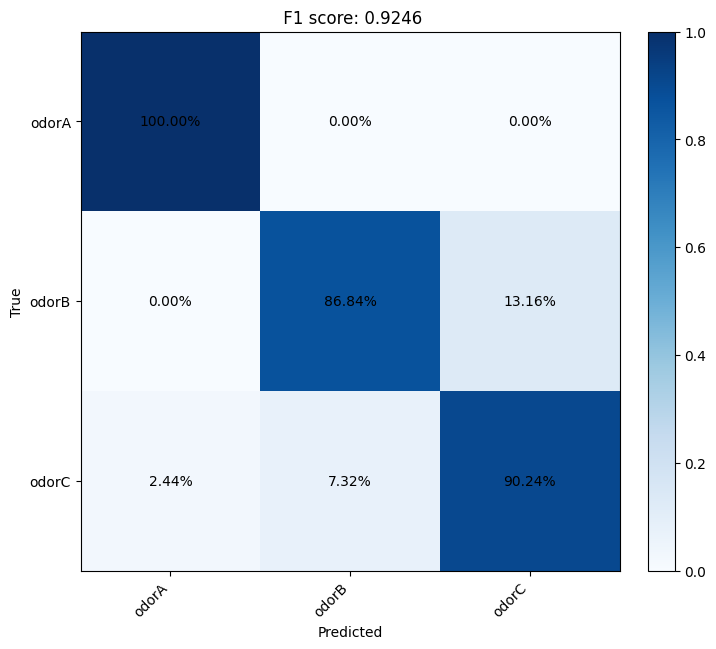

In [7]:
# score on holdout set
holdout_score = cross_validator.score_on_holdout(data_container)

# plot confusion matrix
cross_validator.plot_confusion_matrix()

In [8]:
# examine calculated scores/confusion matrices, available after running cross_validate or score_on_holdout
print("Out of fold")
print(f"F1 score: {cross_validator.oof_f1_score_}")
print(f"Confusion matrix: \n{cross_validator.oof_confusion_matrix_}")

print("Holdout")
print(f"F1 score: {cross_validator.holdout_f1_score_}")
print(f"Confusion matrix: \n{cross_validator.holdout_confusion_matrix_}")

Out of fold
F1 score: 0.9083523781470497
Confusion matrix: 
[[163   0   3]
 [  0 132  20]
 [  3  18 141]]
Holdout
F1 score: 0.9246011071312276
Confusion matrix: 
[[41  0  0]
 [ 0 33  5]
 [ 1  3 37]]


## Perform tuning



### Create parameter grids (generic example)
Parameter grids specify the search space for tuning. They need to use the same pipeline/step names as those in the corresponding `Pipeline`. 

In [9]:
param_grid = {
    "generic_pipeline": {
        "multitaper": {
            "num_time_windows": (1, 5),
            "time_halfbandwidth_product": (1, 3),
        },
        "pca": {
            "n_components": (10, 50),
        },
        "logreg": {
            "C": ("log", 0.01, 10.0),
        },
    }
}

### Run tuning
Tuning can be set up easily with `run_tuning_pipeline`, which calls tuning using `Tuner` and outputs different plots you can specify for visualization. 

Note: if random_state is set in cross-validator, you will get the same train/val/test splits. However, you may still get different results when you run `run_tuning_pipeline` multiple times since the way Optuna chooses new parameters with each trial is non-deterministic. Setting the random seed in Tuner injects the same random seed in different parts of the pipeline (for each transform and for packages like numpy) to make each chosen Pipeline deterministic, but does not make parameter tuning itself deterministic. 

Tuning with seed 0


[I 2026-02-12 15:09:34,034] A new study created in memory with name: no-name-a495f7ec-143c-4d71-a851-7edb7d451f3f


Enqueued initial trial with params: {'pipeline': 'generic_pipeline', 'generic_pipeline__multitaper__num_time_windows': 4, 'generic_pipeline__multitaper__time_halfbandwidth_product': 2, 'generic_pipeline__pca__n_components': 30, 'generic_pipeline__logreg__C': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Checking cache
Cache path: /Users/julien/.cache/xdflow/fit_transform/c8061de34a89ce564e3f7f8b2c0d6e02.pkl Cache exists: True
pipeline_template Pipeline(name='generic_pipeline_dynamic', steps=['multitaper': MultiTaperTransform, 'flatten': FlattenTransform, 'pca': SKLearnTransformer, 'logreg': SKLearnPredictor])
[I 2026-02-12 15:09:36,752] Trial 0 finished with value: 0.9083990999297799 and parameters: {'pipeline': 'generic_pipeline', 'generic_pipeline__multitaper__num_time_windows': 4, 'generic_pipeline__multitaper__time_halfbandwidth_product': 2, 'generic_pipeline__pca__n_components': 30, 'generic_pipeline__logreg__C': 1.0}. Best is trial 0 with value: 0.9083990999297799.
Checking cache
Cache path: /Users/julien/.cache/xdflow/fit_transform/c8061de34a89ce564e3f7f8b2c0d6e02.pkl Cache exists: True
pipeline_template Pipeline(name='generic_pipeline_dynamic', steps=['multitaper': MultiTaperTransform, 'flatten': FlattenTransform, 'pca': SKLearnTransformer, 'logreg': SKLearnPredictor])
[I 2026

[I 2026-02-12 15:10:09,626] A new study created in memory with name: no-name-7e63115f-d681-423f-8007-32c1596015fd


Tuning with seed 1
Enqueued initial trial with params: {'pipeline': 'generic_pipeline', 'generic_pipeline__multitaper__num_time_windows': 4, 'generic_pipeline__multitaper__time_halfbandwidth_product': 2, 'generic_pipeline__pca__n_components': 30, 'generic_pipeline__logreg__C': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Checking cache
Cache path: /Users/julien/.cache/xdflow/fit_transform/c8061de34a89ce564e3f7f8b2c0d6e02.pkl Cache exists: True
pipeline_template Pipeline(name='generic_pipeline_dynamic', steps=['multitaper': MultiTaperTransform, 'flatten': FlattenTransform, 'pca': SKLearnTransformer, 'logreg': SKLearnPredictor])
[I 2026-02-12 15:10:12,611] Trial 0 finished with value: 0.9203092882230426 and parameters: {'pipeline': 'generic_pipeline', 'generic_pipeline__multitaper__num_time_windows': 4, 'generic_pipeline__multitaper__time_halfbandwidth_product': 2, 'generic_pipeline__pca__n_components': 30, 'generic_pipeline__logreg__C': 1.0}. Best is trial 0 with value: 0.9203092882230426.
Checking cache
Cache path: /Users/julien/.cache/xdflow/fit_transform/c8061de34a89ce564e3f7f8b2c0d6e02.pkl Cache exists: True
pipeline_template Pipeline(name='generic_pipeline_dynamic', steps=['multitaper': MultiTaperTransform, 'flatten': FlattenTransform, 'pca': SKLearnTransformer, 'logreg': SKLearnPredictor])
[I 2026

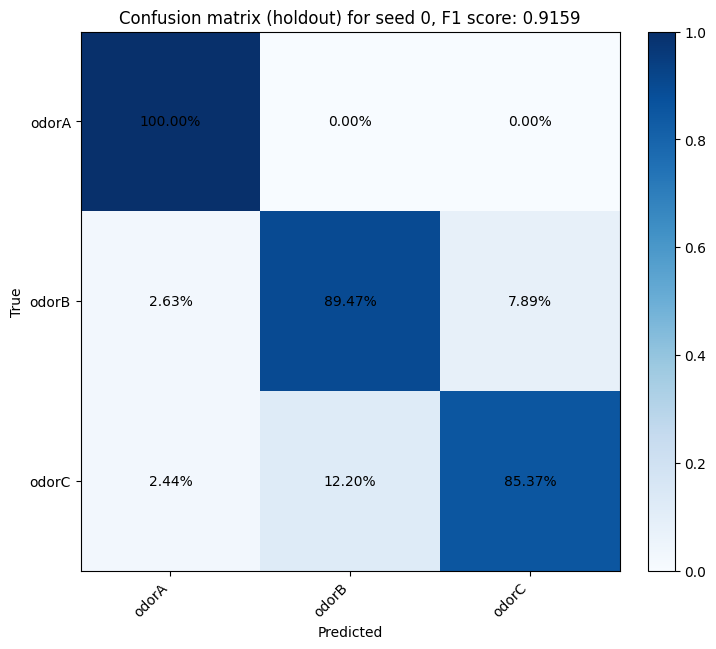

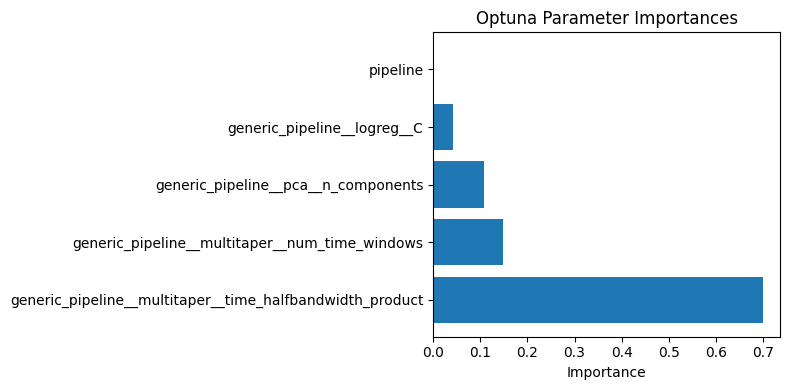

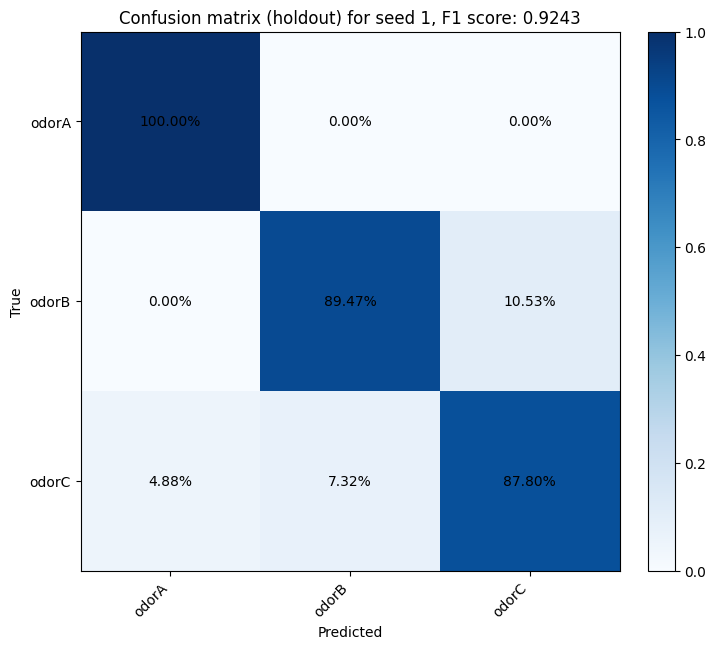

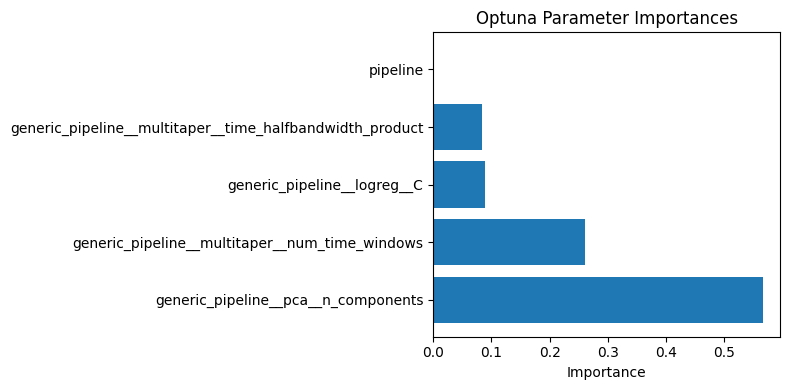

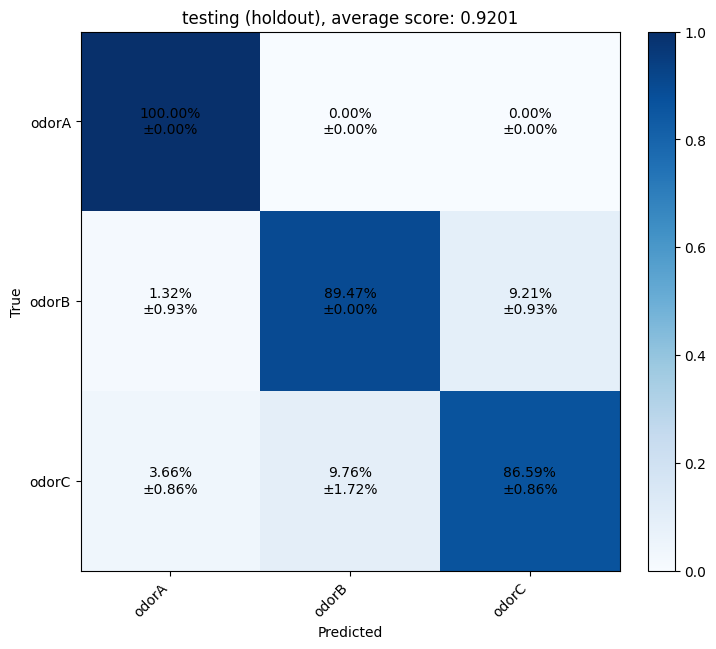

In [10]:
import logging

from xdflow.tuning.tuner_utils import run_tuning_pipeline

logging.getLogger("alembic").setLevel(logging.WARNING)
logging.getLogger("mlflow").setLevel(logging.WARNING)

cross_validator = KFoldValidator(n_splits=5, shuffle=True, random_state=0, test_size=0.2, verbose=False)
mlflow_metadata = {"meta_data_info": "meta_data_values"}  # example metadata to log to mlflow

finalized_pipelines = run_tuning_pipeline(
    pipelines_to_tune=pipeline,
    cv_strategy=cross_validator,
    param_grid=param_grid,
    initial_data_container=data_container,
    experiment_name="testing",
    mlflow_metadata=mlflow_metadata,
    n_seeds=2,
    n_trials=10,  # decrease for faster test tuning, increase for better results
    plot_importances=True,
    plot_combined_conf_matrix=True,
    plot_each_seed_conf_matrix=True,
    return_pipelines=True,
    log_artifacts=False,
)